In [320]:
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import pyspark.ml.linalg
from datetime import datetime
import pandas as pd
import numpy as np

```Import Data```

In [321]:
df = spark.read.format('csv').option('header','true').option('inferSchema','true').load('gs://finalpro/Motor_Vehicle_Collisions_-_Crashes.csv')
vehicle = spark.read.format('csv').option('header','true').option('inferSchema','true').load('gs://finalpro/Vehicle__Snowmobile__and_Boat_Registrations.csv')
vc = spark.read.format('csv').option('header','true').option('inferSchema','true').load('gs://finalpro/Traffic_Volume_Counts__2014-2018_.csv')

In [323]:
df.printSchema()

root
 |-- ACCIDENT DATE: string (nullable = true)
 |-- ACCIDENT TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2:

```Basic Analysis```

In [327]:
accident = df.withColumnRenamed('ACCIDENT DATE','date').withColumnRenamed('ACCIDENT TIME','time').withColumnRenamed('NUMBER OF PERSONS INJURED','npi').select('date','time','BOROUGH','LATITUDE','LONGITUDE','npi').rdd
accident_14_18 = accident.map(lambda x: (x[0].split('/'),x[1].split(':')[0],x[2],x[3],x[4],x[5])).filter(lambda x: x[0][0]!=' PARKING LOT)."' and x[0][2] in ['2014','2015','2016','2017','2018']).map(lambda x: (x[0][2],x[1],x[2],x[3],x[4],x[5])).filter(lambda x: x[2]!=None and x[3]!=None and x[4]!=None)
accident_14 = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[0] == '2014')
accident_15 = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[0] == '2015')
accident_16 = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[0] == '2016')
accident_17 = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[0] == '2017')
accident_18 = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[0] == '2018')
accident_man = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[2] == 'MANHATTAN')
accident_broo = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[2] == 'BROOKLYN')
accident_brx = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[2] == 'BRONX')
accident_si = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[2] == 'STATEN ISLAND')
accident_q = accident_14_18.map(lambda x: (x[0],x[1],x[2],x[5])).filter(lambda x: x[2] == 'QUEENS')



In [328]:
accident_14_18.take(5)

[('2018', '15', 'BRONX', 40.867664, -73.83768, '0'),
 ('2018', '14', 'BRONX', 40.8518, -73.787895, '0'),
 ('2018', '12', 'MANHATTAN', 40.72018, -73.99604, '0'),
 ('2018', '22', 'QUEENS', 40.76705, -73.88841, '0'),
 ('2018', '13', 'QUEENS', 40.772987, -73.9164, '1')]

In [329]:
timeline_14 = accident_14.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_15 = accident_15.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_16 = accident_16.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_17 = accident_17.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_18 = accident_18.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_man = accident_man.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_broo = accident_broo.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_brx = accident_brx.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_si = accident_si.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_q = accident_q.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline_allyear = accident_14_18.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])


In [184]:
db14 = timeline_14.toDF().toPandas()
full_table_id = 'finalPro.14count'
project_id = 'bigdatahw3'
db14.to_gbq(full_table_id, project_id=project_id, if_exists='replace')

1it [00:10, 10.05s/it]


In [341]:
collision_count = timeline_allyear.map(lambda x: x[1]).collect()
harlem_count = [4924,3397,2683,2255,3302,4724,6993,10446,10851,8815,8146,8811,9835,10748,11172,11602,11882,12010,11179,10138,9381,7884,7131,5996]
hhp_count = [164346,103757,70733,56241,64002,114147,257019,339218,375763,355449,358246,376967,382745,392198,435193,477074,486930,486196,475253,411939,345039,300074,262991,218177]
ave3_count = [94934,71819,56392,47977,48962,65609,111600,151200,162190,161092,163321,169590,175247,181197,190052,201841,206218,207166,196353,175721,150093,129854,116003,105453]

cor_df = pd.DataFrame({'collision':collision_count, 'harlem':harlem_count,'hhp':hhp_count, 'Ave3':ave3_count})
cor_df.corr(method ='pearson')

,collision,harlem,hhp,Ave3
collision,1.000000,0.909742,0.944619,0.960741
harlem,0.909742,1.000000,0.980538,0.973578
hhp,0.944619,0.980538,1.000000,0.995146
Ave3,0.960741,0.973578,0.995146,1.000000


In [315]:
contribution = df.withColumnRenamed('ACCIDENT DATE','date').withColumnRenamed('ACCIDENT TIME','time').withColumnRenamed('NUMBER OF PERSONS INJURED','npi').withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 1','con').withColumnRenamed('CONTRIBUTING FACTOR VEHICLE 2','cont').select('date','time','BOROUGH','LATITUDE','LONGITUDE','npi','con','cont').rdd
contri = contribution.map(lambda x: (x[0].split('/'),x[1].split(':')[0],x[2],x[3],x[4],x[5],x[6],x[7])).filter(lambda x: x[0][0]!=' PARKING LOT)."' and x[0][2] in ['2014','2015','2016','2017','2018']).map(lambda x: (x[0][2],x[1],x[2],x[3],x[4],x[5],x[6],x[7])).filter(lambda x: x[2]!=None and x[3]!=None and x[4]!=None and x[5]!='0').filter(lambda x: x[6]!='Unspecified' or x[7]!='Unspecified').filter(lambda x: x[6]!=None or x[7]!=None)
con1 = contri.map(lambda x: (x[6],1)).reduceByKey(lambda v1,v2: v1+v2).sortBy(lambda x: -x[1])
con2 = contri.map(lambda x: (x[7],1)).reduceByKey(lambda v1,v2: v1+v2).sortBy(lambda x: -x[1])
contri.count()
# and x[0][2]=='2018'

107578

[26702, 18627, 16095, 4726, 4525, 3291, 2940, 2627, 2138, 2042, 2024, 1821, 1786, 1757, 1751, 1623, 1349, 1239, 1109, 1006, 8400]
['Driver Inattention/Distraction', 'Unspecified', 'Failure to Yield Right-of-Way', 'Following Too Closely', 'Traffic Control Disregarded', 'Other Vehicular', 'Backing Unsafely', 'Fatigued/Drowsy', 'Turning Improperly', 'Alcohol Involvement', 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'Unsafe Speed', 'Driver Inexperience', 'Passenger Distraction', 'Physical Disability', 'Passing or Lane Usage Improper', 'Pavement Slippery', 'View Obstructed/Limited', 'Prescription Medication', 'Lost Consciousness', 'others']


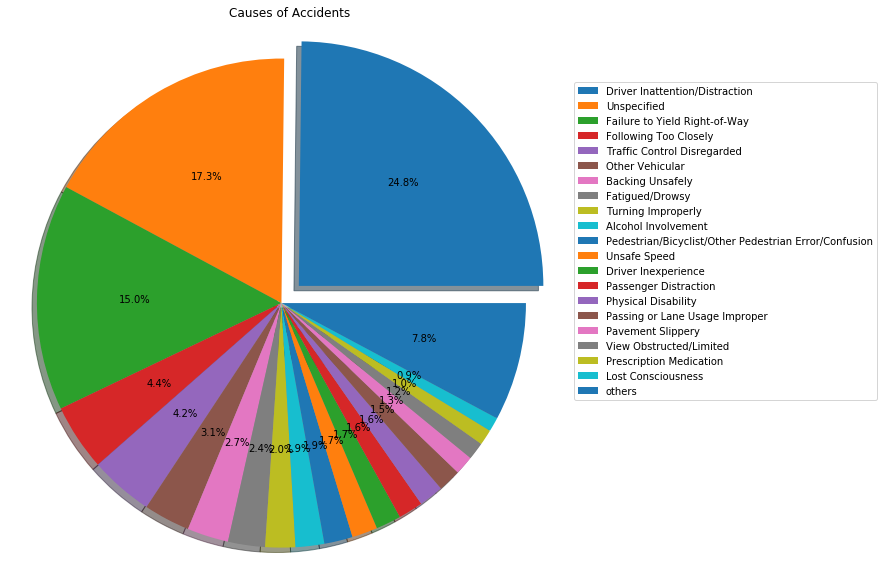

In [319]:
cont = con1.collect()
con_count = []
reason = []
#len(con1) = 60
for i in range(20):
    reason.append(cont[i][0])
    con_count.append(int(cont[i][1]))
reason.append('others')
other = 0
for i in range(20,len(cont)):
    other = other+cont[i][1]
con_count.append(other)
print(con_count)
print(reason)
ex = [0]*21
ex[0] = 0.1
plt.figure(figsize=(10,10))
plt.pie(con_count,explode = ex,autopct='%1.1f%%',shadow = True)
plt.axis('equal')
plt.legend(reason, bbox_to_anchor=(1, 0.9))
plt.title('Causes of Accidents')
plt.show()

In [286]:
timeline = accident_14_18.map(lambda x: (x[1],1)).reduceByKey(lambda v1,v2: v1+v2).map(lambda x: (int(x[0]),x[1])).sortBy(lambda x: x[0])
timeline.take(100)

[(0, 4186),
 (1, 2192),
 (2, 1749),
 (3, 1567),
 (4, 1849),
 (5, 1926),
 (6, 2937),
 (7, 4029),
 (8, 7260),
 (9, 6279),
 (10, 5392),
 (11, 5948),
 (12, 6641),
 (13, 7218),
 (14, 8433),
 (15, 8533),
 (16, 9509),
 (17, 9933),
 (18, 9629),
 (19, 8165),
 (20, 7139),
 (21, 5940),
 (22, 5185),
 (23, 4218)]

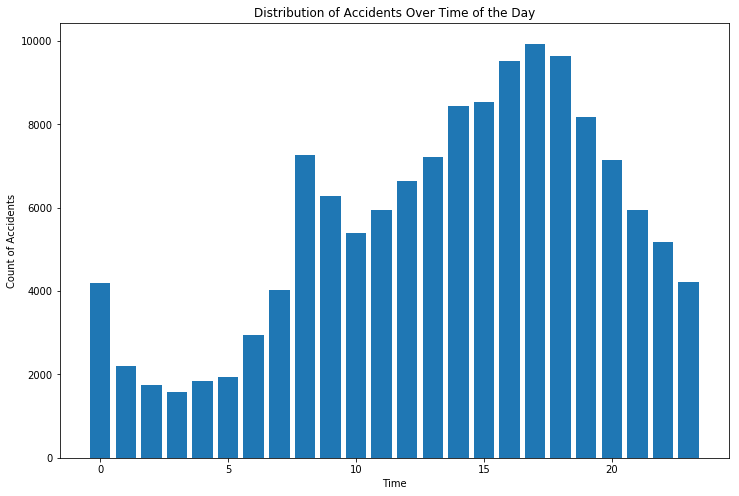

In [290]:
timelist = timeline.collect()
h = []
c = []
for i in timelist:
    h.append(i[0])
    c.append(i[1])
plt.figure(figsize=(12,8))
plt.bar(h,c)
plt.title('Distribution of Accidents Over Time of the Day')
plt.xlabel('Time')
plt.ylabel('Count of Accidents')
plt.show()

```Analysis on Vehicle Type```

In [358]:
cartype = df.withColumnRenamed('ACCIDENT DATE','date').withColumnRenamed('VEHICLE TYPE CODE 1','type1').withColumnRenamed('NUMBER OF PERSONS INJURED','npi').withColumnRenamed('VEHICLE TYPE CODE 2','type2').select('date','npi','type1').rdd
cartype = cartype.map(lambda x: (x[0].split('/'),x[1],x[2])).filter(lambda x: x[0][0]!=' PARKING LOT)."' and x[0][2] in ['2018','2019']).filter(lambda x: x[2]!=None)
cartype = cartype.map(lambda x: x[2].upper()).filter(lambda x: x!='UNKNOWN' and x!='OTHER')
cartype = cartype.map(lambda x: (x,1)).reduceByKey(lambda x1,x2: x1+x2).filter(lambda x: x[1]>500).sortBy(lambda x: -x[1])
cartype.count()

412688

In [117]:
def coma(x):
    x = list(x)
    if ',' in x:
        x.remove(',')
    s = ""
    for i in x:
        s = s + i
    s = int(s)
    return s

In [123]:
nys = vt.withColumnRenamed('Body Type','type').withColumnRenamed('Registration Class','number').select('type','number').rdd
nys = nys.map(lambda x:(x[0].upper(),x[1])).map(lambda x: (x[0],coma(x[1]))).reduceByKey(lambda x1,x2: x1+x2).sortBy(lambda x:-x[1])
nys.take(59)

[('SUBN', 5025317),
 ('4DSD', 3486915),
 ('PICK', 449811),
 ('LTRL', 441271),
 ('2DSD', 436795),
 ('BOAT', 386295),
 ('MCY ', 348649),
 ('TRLR', 276313),
 ('VAN ', 230252),
 ('CONV', 173706),
 ('ATV ', 96577),
 ('DUMP', 82841),
 ('H/TR', 81117),
 ('BUS ', 61165),
 ('UTIL', 49514),
 ('SEMI', 44573),
 ('TRAC', 36082),
 ('SNOW', 34577),
 ('H/WH', 26509),
 ('DELV', 24746),
 ('FLAT', 22500),
 ('TAXI', 11082),
 ('P/SH', 10174),
 ('STAK', 9693),
 ('TANK', 8931),
 ('MOPD', 7455),
 ('TOW ', 6694),
 ('REFG', 5455),
 ('SEDN', 5228),
 ('RBM ', 4763),
 ('RD/S', 2512),
 ('CMIX', 2488),
 ('TR/C', 2318),
 ('CUST', 1754),
 ('AMBU', 1307),
 ('LSV ', 1075),
 ('S/SP', 1038),
 ('FIRE', 985),
 ('T/CR', 866),
 ('HRSE', 838),
 ('LIM ', 811),
 ('SN/P', 786),
 ('SWT ', 775),
 ('EMVR', 579),
 ('W/DR', 477),
 ('DCOM', 363),
 ('????', 293),
 ('W/SR', 252),
 ('R/RD', 212),
 ('FPM ', 83),
 ('MCC ', 82),
 ('TRAV', 58),
 ('LSVT', 43),
 ('H/IN', 36),
 ('POLE', 32),
 ('LOCO', 24),
 ('TR/E', 21),
 ('RPLC', 12),
 ('MFH ',

In [130]:
vehicle.printSchema()

root
 |-- Record Type: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- Registration Class: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Unladen Weight: string (nullable = true)
 |-- Maximum Gross Weight: string (nullable = true)
 |-- Passengers: integer (nullable = true)
 |-- Reg Valid Date: string (nullable = true)
 |-- Reg Expiration Date: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Scofflaw Indicator: string (nullable = true)
 |-- Suspension Indicator: string (nullable = true)
 |-- Revocation Indicator: string (nullable = true)



In [360]:
vehicle_type = vehicle.withColumnRenamed('Body Type','type').select('Record Type','County','City','type').rdd
veh = vehicle_type.map(lambda x: (x[0].upper(),x[1].upper(),x[2].upper(),x[3].upper())).filter(lambda x: x[0]=='VEH ').filter(lambda x: (x[1] in ['BROOKLYN       ','BRONX          ','NEW YORK       ','QUEENS      ','STATEN ISLAND  ']) or x[2] in ['BROOKLYN       ','BRONX          ','NEW YORK       ','QUEENS      ','STATEN ISLAND  '])
veh = veh.map(lambda x: (x[3],1)).reduceByKey(lambda x1,x2: x1+x2).sortBy(lambda x:-x[1])
veh.take(10)

[('SUBN', 1143226),
 ('4DSD', 763959),
 ('2DSD', 72420),
 ('VAN ', 51390),
 ('MCY ', 45912),
 ('CONV', 23350),
 ('BUS ', 17426),
 ('PICK', 10984),
 ('TAXI', 10283),
 ('DELV', 9316)]

```Analysis on Traffic Volume```

In [325]:
def no_coma(x):
    x = list(x)
    res = []
    for i in x:
        i = list(i)
        if ',' in i:
            #print(i)
            i.remove(',')
            #print(i)
        s = ""
        for j in i:
            s = s + j
        res.append(s)
    res = tuple(res)
    return res


In [326]:
tc = vc.withColumnRenamed('12:00-1:00 AM','0:00').withColumnRenamed('1:00-2:00AM','1:00').withColumnRenamed('2:00-3:00AM','2:00').withColumnRenamed('3:00-4:00AM','3:00').withColumnRenamed('4:00-5:00AM','4:00').withColumnRenamed('5:00-6:00AM','5:00').withColumnRenamed('6:00-7:00AM','6:00')
tc = tc.withColumnRenamed('7:00-8:00AM','7:00').withColumnRenamed('8:00-9:00AM','8:00').withColumnRenamed('9:00-10:00AM','9:00').withColumnRenamed('10:00-11:00AM','10:00').withColumnRenamed('11:00-12:00PM','11:00').withColumnRenamed('12:00-1:00PM','12:00').withColumnRenamed('1:00-2:00PM','13:00')
tc = tc.withColumnRenamed('2:00-3:00PM','14:00').withColumnRenamed('3:00-4:00PM','15:00').withColumnRenamed('4:00-5:00PM','16:00').withColumnRenamed('5:00-6:00PM','17:00').withColumnRenamed('6:00-7:00PM','18:00').withColumnRenamed('7:00-8:00PM','19:00').withColumnRenamed('8:00-9:00PM','20:00')
tc = tc.withColumnRenamed('9:00-10:00PM','21:00').withColumnRenamed('10:00-11:00PM','22:00').withColumnRenamed('11:00-12:00AM','23:00')
tc = tc.withColumnRenamed('Roadway Name','Road').rdd
tc = tc.map(lambda x: (x[6],x[2].upper(),x[3].upper(),x[4].upper(),x[5].upper(),x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30]))
harlem = tc.filter(lambda x: x[1]=='HARLEM RIVER DRIVEWAY')

harlem = harlem.map(lambda x: no_coma(x)).map(lambda x: (x[0],x[1],x[2],x[3],x[4],int(x[5]),int(x[6]),int(x[7]),int(x[8]),int(x[9]),int(x[10]),int(x[11]),int(x[12]),int(x[13]),int(x[14]),int(x[15]),int(x[16]),int(x[17]),int(x[18]),int(x[19]),int(x[20]),int(x[21]),int(x[22]),int(x[23]),int(x[24]),int(x[25]),int(x[26]),int(x[27]),int(x[28])))
harlem = harlem.map(lambda x: (x[1],(x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))).reduceByKey(lambda x1,x2: tuple(np.array(x1)+np.array(x2)))
harlem.map(lambda x: x[1])

[('HARLEM RIVER DRIVEWAY',
  (4924,
   3397,
   2683,
   2255,
   3302,
   4724,
   6993,
   10446,
   10851,
   8815,
   8146,
   8811,
   9835,
   10748,
   11172,
   11602,
   11882,
   12010,
   11179,
   10138,
   9381,
   7884,
   7131,
   5996))]

In [313]:
ave3 = tc.filter(lambda x: x[1]=='3 AVENUE')
#ave3.count()
ave3 = ave3.map(lambda x: no_coma(x)).map(lambda x: (x[0],x[1],x[2],x[3],x[4],int(x[5]),int(x[6]),int(x[7]),int(x[8]),int(x[9]),int(x[10]),int(x[11]),int(x[12]),int(x[13]),int(x[14]),int(x[15]),int(x[16]),int(x[17]),int(x[18]),int(x[19]),int(x[20]),int(x[21]),int(x[22]),int(x[23]),int(x[24]),int(x[25]),int(x[26]),int(x[27]),int(x[28])))
ave3 = ave3.map(lambda x: (x[1],(x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))).reduceByKey(lambda x1,x2: tuple(np.array(x1)+np.array(x2)))
ave3.take(5)

280

In [314]:
hhp = tc.filter(lambda x: x[1]=='HENRY HUDSON PARKWAY')
#hhp.count()
hhp = hhp.map(lambda x: no_coma(x)).map(lambda x: (x[0],x[1],x[2],x[3],x[4],int(x[5]),int(x[6]),int(x[7]),int(x[8]),int(x[9]),int(x[10]),int(x[11]),int(x[12]),int(x[13]),int(x[14]),int(x[15]),int(x[16]),int(x[17]),int(x[18]),int(x[19]),int(x[20]),int(x[21]),int(x[22]),int(x[23]),int(x[24]),int(x[25]),int(x[26]),int(x[27]),int(x[28])))
hhp = hhp.map(lambda x: (x[1],(x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))).reduceByKey(lambda x1,x2: tuple(np.array(x1)+np.array(x2)))
hhp.take(5)

162

[ 678  512  402  342  349  468  797 1080 1158 1150 1166 1211 1251 1294
 1357 1441 1472 1479 1402 1255 1072  927  828  753]


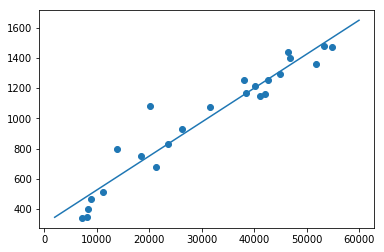

In [353]:
harlem_count = [4924,3397,2683,2255,3302,4724,6993,10446,10851,8815,8146,8811,9835,10748,11172,11602,11882,12010,11179,10138,9381,7884,7131,5996]
collision_count = [21255,11122,8387,7275,8177,8835,13949,20087,42016,41160,38552,40203,42715,44903,51820,46491,54911,53287,46868,38109,31639,26340,23597,18375]
ave3_count = np.array([94934,71819,56392,47977,48962,65609,111600,151200,162190,161092,163321,169590,175247,181197,190052,201841,206218,207166,196353,175721,150093,129854,116003,105453])
ave3_count = ave3_count//140
print(ave3_count)
plt.figure()
plt.scatter(collision_count,ave3_count)
x = np.arange(2000,60000,0.5)
y = 0.02244945*x+301.2402910639797
plt.plot(x,y)




In [341]:
collision_count = timeline_allyear.map(lambda x: x[1]).collect()
harlem_count = [4924,3397,2683,2255,3302,4724,6993,10446,10851,8815,8146,8811,9835,10748,11172,11602,11882,12010,11179,10138,9381,7884,7131,5996]
hhp_count = [164346,103757,70733,56241,64002,114147,257019,339218,375763,355449,358246,376967,382745,392198,435193,477074,486930,486196,475253,411939,345039,300074,262991,218177]
ave3_count = [94934,71819,56392,47977,48962,65609,111600,151200,162190,161092,163321,169590,175247,181197,190052,201841,206218,207166,196353,175721,150093,129854,116003,105453]

cor_df = pd.DataFrame({'collision':collision_count, 'harlem':harlem_count,'hhp':hhp_count, 'Ave3':ave3_count})
cor_df.corr(method ='pearson')

,collision,harlem,hhp,Ave3
collision,1.000000,0.909742,0.944619,0.960741
harlem,0.909742,1.000000,0.980538,0.973578
hhp,0.944619,0.980538,1.000000,0.995146
Ave3,0.960741,0.973578,0.995146,1.000000
